In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo 
import xgboost as xgb
from sklearn.impute import SimpleImputer
  
# fetch dataset 
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938) 
  
# data (as pandas dataframes) 
X = regensburg_pediatric_appendicitis.data.features 
y = regensburg_pediatric_appendicitis.data.targets

# Merging X and y to data
data = pd.merge(X, y, left_index=True, right_index=True)
data.shape

(782, 56)

In [62]:
# deleting not needed target variables from data
data = data.drop(['Management', 'Severity'], axis=1)
data.shape

(782, 54)

In [63]:
# removing all NAN values from diagnosis
data = data.dropna(subset=['Diagnosis'])
data.shape

(780, 54)

In [64]:
# Checking for NAN values
data[data['Diagnosis'].isna()]

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings,Diagnosis


In [65]:
# storing it in y
y = data["Diagnosis"]

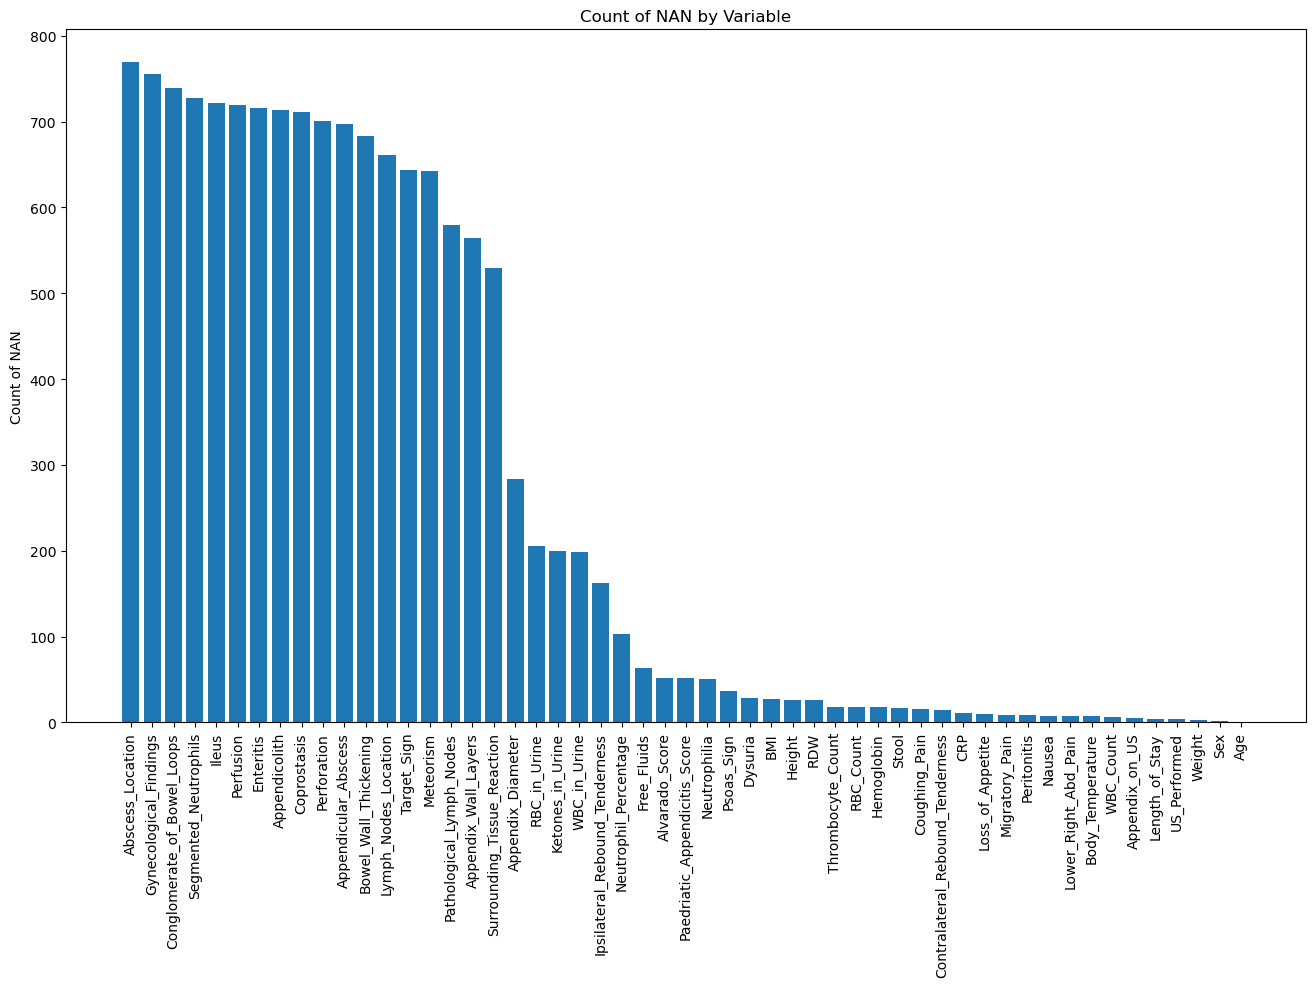

In [66]:
# visualizing count of NAN values
nan_counts = X.isna().sum()
nan_counts_sorted = nan_counts.sort_values(ascending=False)  # Sort values in descending order

plt.figure(figsize=(16, 9))
plt.bar(nan_counts_sorted.index, nan_counts_sorted.values)
plt.xticks(rotation=90)
plt.title('Count of NAN by Variable')
plt.ylabel('Count of NAN')
plt.show()

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 781
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               780 non-null    float64
 1   BMI                               754 non-null    float64
 2   Sex                               779 non-null    object 
 3   Height                            755 non-null    float64
 4   Weight                            778 non-null    float64
 5   Length_of_Stay                    777 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Paedriatic_Appendicitis_Score     730 non-null    float64
 8   Appendix_on_US                    777 non-null    object 
 9   Appendix_Diameter                 498 non-null    float64
 10  Migratory_Pain                    773 non-null    object 
 11  Lower_Right_Abd_Pain              774 non-null    object 
 12  Contrala

In [69]:
object_columns = data.select_dtypes(include=['object'])
object_columns.columns

Index(['Sex', 'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Neutrophilia', 'Ketones_in_Urine', 'RBC_in_Urine',
       'WBC_in_Urine', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign',
       'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids',
       'Appendix_Wall_Layers', 'Target_Sign', 'Appendicolith', 'Perfusion',
       'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
       'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location',
       'Bowel_Wall_Thickening', 'Conglomerate_of_Bowel_Loops', 'Ileus',
       'Coprostasis', 'Meteorism', 'Enteritis', 'Gynecological_Findings',
       'Diagnosis'],
      dtype='object')

In [70]:
# Transforming columns from text to numeric
data["Sex"] = data["Sex"].apply(lambda x: 1 if x == "female" else 0)
data["Appendix_on_US"] = data["Appendix_on_US"].apply(lambda x: 1 if x == "yes" else 0)
data["Migratory_Pain"] = data["Migratory_Pain"].apply(lambda x: 1 if x == "yes" else 0)
data["Lower_Right_Abd_Pain"] = data["Lower_Right_Abd_Pain"].apply(lambda x: 1 if x == "yes" else 0)
data["Contralateral_Rebound_Tenderness"] = data["Contralateral_Rebound_Tenderness"].apply(lambda x: 1 if x == "yes" else 0)
data["Coughing_Pain"] = data["Coughing_Pain"].apply(lambda x: 1 if x == "yes" else 0)
data["Nausea"] = data["Nausea"].apply(lambda x: 1 if x == "yes" else 0)
data["Loss_of_Appetite"] = data["Loss_of_Appetite"].apply(lambda x: 1 if x == "yes" else 0)
data["Neutrophilia"] = data["Neutrophilia"].apply(lambda x: 1 if x == "yes" else 0)

ketones_mapping = {"no": 0, "+": 1, "++": 2, "+++": 3}
data["Ketones_in_Urine"] = data["Ketones_in_Urine"].map(ketones_mapping)

rbc_mapping = {"no": 0, "+": 1, "++": 2, "+++": 3}
data["RBC_in_Urine"] = data["RBC_in_Urine"].map(rbc_mapping)

wbc_mapping = {"no": 0, "+": 1, "++": 2, "+++": 3}
data["WBC_in_Urine"] = data["WBC_in_Urine"].map(wbc_mapping)

data["Dysuria"] = data["Dysuria"].apply(lambda x: 1 if x == "yes" else 0)

stool_mapping = {"normal": 0, "diarrhea": 1, "constipation": 2, "constipation, diarrhea": 3}
data["Stool"] = data["Stool"].map(stool_mapping)

peritonitis_mapping = {"no": 0, "local": 1, "generalized": 2}
data["Peritonitis"] = data["Peritonitis"].map(peritonitis_mapping)

data["Psoas_Sign"] = data["Psoas_Sign"].apply(lambda x: 1 if x == "yes" else 0)
data["Ipsilateral_Rebound_Tenderness"] = data["Ipsilateral_Rebound_Tenderness"].apply(lambda x: 1 if x == "yes" else 0)
data["US_Performed"] = data["US_Performed"].apply(lambda x: 1 if x == "yes" else 0)
data["Free_Fluids"] = data["Free_Fluids"].apply(lambda x: 1 if x == "yes" else 0)

wall_mapping = {"intact": 0, "raised": 1, "partially raised": 2, "upset": 3}
data["Appendix_Wall_Layers"] = data["Appendix_Wall_Layers"].map(wall_mapping)

data.loc[:, "Target_Sign"] = data["Target_Sign"].apply(lambda x: 1 if x == "yes" else 0)

app_mapping = {"no": 0, "suspected": 1, "yes": 2}
data["Appendicolith"] = data["Appendicolith"].map(app_mapping)

perfusion_mapping = {"no": 0, "present": 1, "hypoperfused": 2, "hyperperfused": 3}
data["Perfusion"] = data["Perfusion"].map(perfusion_mapping)

perforation_mapping = {"no": 0, "suspected": 1, "not excluded": 2, "yes": 3}
data["Perforation"] = data["Perforation"].map(perfusion_mapping)

data.loc[:, "Surrounding_Tissue_Reaction"] = data["Surrounding_Tissue_Reaction"].apply(lambda x: 1 if x == "yes" else 0)

abscess_mapping = {"no": 0, "suspected": 1, "yes": 2}
data["Appendicular_Abscess"] = data["Appendicular_Abscess"].map(abscess_mapping)

data["Pathological_Lymph_Nodes"] = data["Pathological_Lymph_Nodes"].apply(lambda x: 1 if x == "yes" else 0)
data["Bowel_Wall_Thickening"] = data["Bowel_Wall_Thickening"].apply(lambda x: 1 if x == "yes" else 0)
data["Conglomerate_of_Bowel_Loops"] = data["Conglomerate_of_Bowel_Loops"].apply(lambda x: 1 if x == "yes" else 0)
data["Ileus"] = data["Ileus"].apply(lambda x: 1 if x == "yes" else 0)
data["Coprostasis"] = data["Coprostasis"].apply(lambda x: 1 if x == "yes" else 0)
data["Meteorism"] = data["Meteorism"].apply(lambda x: 1 if x == "yes" else 0)
data["Enteritis"] = data["Enteritis"].apply(lambda x: 1 if x == "yes" else 0)
data["Diagnosis"] = data["Diagnosis"].apply(lambda x: 1 if x == "appendicitis" else 0)

# Dropping columns
data.drop("Abscess_Location", axis=1, inplace=True)
data.drop("Lymph_Nodes_Location", axis=1, inplace=True)
data.drop("Gynecological_Findings", axis=1, inplace=True)

C:\Users\mariu\AppData\Local\Temp\ipykernel_15392\980877032.py:37: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, "Target_Sign"] = data["Target_Sign"].apply(lambda x: 1 if x == "yes" else 0)
C:\Users\mariu\AppData\Local\Temp\ipykernel_15392\980877032.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, "Surrounding_Tissue_Reaction"] = data["Surrounding_Tissue_Reaction"].apply(lambda x: 1 if x == "yes" else 0)


In [71]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(data)
data_mean = pd.DataFrame(imputer.transform(df), columns=data.columns)

In [73]:
data_mean.to_csv('data_mean.csv', index=False)

## Matrix Completion

In [31]:
FEATURES = ['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay',
       'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US',
       'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count',
       'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia',
       'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
       'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria',
       'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness',
       'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign',
       'Appendicolith', 'Perfusion', 'Perforation',
       'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
       'Pathological_Lymph_Nodes', 'Bowel_Wall_Thickening',
       'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism',
       'Enteritis']

In [32]:
# SVD and plotting singular values
plot_data = data[FEATURES].copy()

nan_columns = plot_data.columns[plot_data.isna().any()].tolist()
plot_data[nan_columns] = plot_data[nan_columns].fillna(plot_data.mean())

plot_data_scaled = StandardScaler().fit_transform(plot_data)

# SVD and plotting the singular values
np.set_printoptions(suppress=True)
U, S, V = np.linalg.svd(plot_data_scaled)
S

array([68.64003595, 50.04493014, 41.56847133, 38.86306379, 37.84579141,
       34.75723222, 34.65229476, 33.07844556, 31.85160292, 31.4657376 ,
       30.6912797 , 29.81932164, 29.29962162, 29.24328892, 28.76135411,
       28.62269044, 28.01101078, 27.66895207, 27.53438348, 26.85281042,
       26.3339143 , 26.21230168, 25.76097626, 25.61738385, 25.13699982,
       24.94203245, 24.5220081 , 24.45079237, 24.23248777, 23.63270185,
       23.49001281, 22.91298574, 22.51454469, 22.08370646, 21.95995756,
       21.57194583, 21.08511372, 20.47383088, 20.02539452, 19.53044496,
       18.87200176, 17.76685268, 16.79755752, 15.55223907, 12.43190249,
       11.34805599, 10.51302582,  5.50864595,  4.54261002,  0.        ])

In [33]:
plot_data.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Perforation,Surrounding_Tissue_Reaction,Appendicular_Abscess,Pathological_Lymph_Nodes,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis
0,12.68,16.9,1,148.0,37.0,3.0,4.0,3.0,1,7.100000,...,0.0,1,0.000000,1,0,0,0,0,0,0
1,14.10,31.9,0,147.0,69.5,2.0,5.0,4.0,0,7.762651,...,0.0,0,0.458824,0,0,0,0,0,1,0
2,14.14,23.3,1,163.0,62.0,4.0,5.0,3.0,0,7.762651,...,0.0,0,0.458824,0,0,0,0,0,1,1
3,16.37,20.6,1,165.0,56.0,3.0,7.0,6.0,0,7.762651,...,0.0,0,0.458824,1,0,0,0,0,0,1
4,11.08,16.9,1,163.0,45.0,3.0,5.0,6.0,1,7.000000,...,0.0,0,0.458824,1,0,0,0,0,0,1


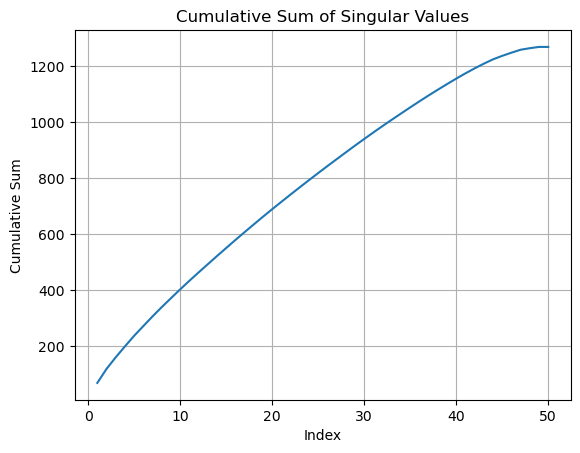

In [34]:
sing_cumsum = np.cumsum(S)
xs = np.arange(1, len(S) + 1, 1)

plt.plot(xs, sing_cumsum)
plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Singular Values')
plt.grid(True)
plt.show()

In [51]:
def find_nan_indices(matrix):
    r_idx, c_idx = np.where(np.isnan(matrix))
    return r_idx.tolist(), c_idx.tolist()

def low_rank(X, M=1): 
    U, D, V = np.linalg.svd(X) 
    L = U[:,:M] * D[None,:M] 
    return L.dot(V[:M])

scaler = StandardScaler()

data_features = data[FEATURES]

data_features_scaled = scaler.fit_transform(data_features)

Xna = data_features_scaled

r_idx, c_idx = find_nan_indices(Xna)

Xhat = Xna.copy()
Xbar = np.nanmean(Xhat, axis=0) 
Xhat[r_idx, c_idx] = Xbar[c_idx]

thresh = 1e-7 
rel_err = 1 
count = 0 
ismiss = np.isnan(Xna) 
mssold = np.mean(Xhat[~ismiss]**2) 
mss0 = np.mean(Xna[~ismiss ]**2)

while rel_err > thresh: 
    count += 1  
    Xapp = low_rank(Xhat, M=35) 
    Xhat[ismiss] = Xapp[ismiss] 
    mss = np.mean(((Xna - Xapp)[~ismiss]) ** 2) 
    rel_err = (mssold - mss) / mss0 
    mssold = mss 
    if count % 100 == 0:
        print("Iteration: {0}, MSS: {1:.3f}, Rel.Err {2:.2e}".format(count, mss, rel_err))

print("+++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("Final Iteration: {0}, MSS: {1:.3f}, Rel.Err {2:.2e}".format(count, mss, rel_err))
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++")

Iteration: 100, MSS: 0.033, Rel.Err 3.16e-05
Iteration: 200, MSS: 0.031, Rel.Err 1.49e-05
Iteration: 300, MSS: 0.030, Rel.Err 6.99e-06
Iteration: 400, MSS: 0.029, Rel.Err 3.70e-06
Iteration: 500, MSS: 0.029, Rel.Err 2.38e-06
Iteration: 600, MSS: 0.029, Rel.Err 1.73e-06
Iteration: 700, MSS: 0.028, Rel.Err 1.34e-06
Iteration: 800, MSS: 0.028, Rel.Err 1.08e-06
Iteration: 900, MSS: 0.028, Rel.Err 8.99e-07
Iteration: 1000, MSS: 0.028, Rel.Err 7.66e-07
Iteration: 1100, MSS: 0.028, Rel.Err 6.66e-07
Iteration: 1200, MSS: 0.028, Rel.Err 5.87e-07
Iteration: 1300, MSS: 0.028, Rel.Err 5.24e-07
Iteration: 1400, MSS: 0.028, Rel.Err 4.73e-07
Iteration: 1500, MSS: 0.028, Rel.Err 4.30e-07
Iteration: 1600, MSS: 0.028, Rel.Err 3.93e-07
Iteration: 1700, MSS: 0.028, Rel.Err 3.62e-07
Iteration: 1800, MSS: 0.028, Rel.Err 3.35e-07
Iteration: 1900, MSS: 0.028, Rel.Err 3.10e-07
Iteration: 2000, MSS: 0.028, Rel.Err 2.89e-07
Iteration: 2100, MSS: 0.028, Rel.Err 2.70e-07
Iteration: 2200, MSS: 0.028, Rel.Err 2.52e-

In [52]:
data_rescaled = scaler.inverse_transform(Xhat)
df = pd.DataFrame(data_rescaled, columns=FEATURES)
df["Diagnosis"] = y
df["Diagnosis"] = df["Diagnosis"].apply(lambda x: 1 if x == "appendicitis" else 0)
df.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Surrounding_Tissue_Reaction,Appendicular_Abscess,Pathological_Lymph_Nodes,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Diagnosis
0,12.68,16.9,1.0,148.0,37.0,3.0,4.0,3.0,1.0,7.100000,...,1.0,0.000000,1.0,0.0,-3.469447e-18,3.469447e-18,0.0,0.0,0.0,1
1,14.10,31.9,0.0,147.0,69.5,2.0,5.0,4.0,0.0,16.335606,...,0.0,0.735945,0.0,0.0,-3.469447e-18,3.469447e-18,0.0,1.0,0.0,0
2,14.14,23.3,1.0,163.0,62.0,4.0,5.0,3.0,0.0,17.258576,...,0.0,-4.590169,0.0,0.0,-3.469447e-18,3.469447e-18,0.0,1.0,1.0,0
3,16.37,20.6,1.0,165.0,56.0,3.0,7.0,6.0,0.0,13.539293,...,0.0,-3.462844,1.0,0.0,-3.469447e-18,3.469447e-18,0.0,0.0,1.0,0
4,11.08,16.9,1.0,163.0,45.0,3.0,5.0,6.0,1.0,7.000000,...,0.0,-5.761531,1.0,0.0,-3.469447e-18,3.469447e-18,0.0,0.0,1.0,1


In [53]:
df.to_csv('data_35.csv', index=False)